# Single-cell expression data classification

More info about this project in the [README](README.md) file

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing, metrics

from dl85 import DL85Classifier

In [2]:
# File names

train_fn = "dataset/single_cell_expression-train.csv"
test_fn = "dataset/single_cell_expression-test.csv"
test_labels_fn = "dataset/single_cell_expression-test_labels.csv"

output_fn = None  # no output

> The "test labels" file is of course not given in a ML competition. It was added afterwards in order to be able to evaluate the performance and its perofrmance estimation.

In [3]:
target = "label"

RANDOM_STATE = None
np.random.seed(RANDOM_STATE)

In [4]:
# Preprocessing parameters

correlation_threshold = 0.9
variance_threshold = 0.1

## Data frames creation and dataset insight information examination

In [5]:
%%time

train_df = pd.read_csv(train_fn, index_col=0, na_values=["NA"])
test_df = pd.read_csv(test_fn, index_col=0, na_values=["NA"])
test_labels_df = pd.read_csv(test_labels_fn, index_col=0)

Wall time: 27 s


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, C-1 to C-1000
Columns: 23385 entries, A1BG to label
dtypes: bool(8), float64(23371), int64(2), object(4)
memory usage: 178.4+ MB


> We can already see that the dataset 
* is high-dimensional (23384 features, 1 label)
* contains both numerical (floats and ints) and categorical (bools and objects) features

In [7]:
pd.set_option("display.max_columns", 40)
train_df.head()

,A1BG,NAT2,ADA,CDH2,AKT3,GAGE12F,ZBTB11-AS1,MED6,NR2E3,NAALAD2,SNORD116-1,SNORD116-2,SNORD116-3,SNORD116-4,SNORD116-5,SNORD116-8,SNORD116-10,SNORD116-11,SNORD116-12,SNORD116-13,...,PTBP3,KCNE2,DGCR2,CASP8AP2,SCO2,patient,tissue,size,level.mito,level.ribo,low.yield,reads,marker.A,marker.B,marker.C,marker.D,marker.E,marker.F,marker.G,label
C-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,Alpha,Periferal blood,1.916922,High,High,False,1483135,True,False,True,True,True,False,True,-1
C-2,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,91.0,0.0,366.0,0.0,0.0,Beta,Periferal blood,1.866695,Normal,Normal,False,1446762,True,False,True,False,True,False,False,-1
C-3,0.0,0.0,134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,111.0,0.0,0.0,0.0,0.0,Beta,Tumor-infiltrating,0.915932,Normal,Normal,False,1244242,True,False,True,True,True,False,True,-1
C-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,469.0,NaN,0.0,0.0,0.0,Gamma,Normal,0.659181,Normal,Normal,False,886753,True,False,True,False,True,True,False,-1
C-5,0.0,0.0,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,Alpha,Periferal blood,0.590000,Normal,High,False,1095474,False,True,True,True,True,False,True,1


In [8]:
# Count number of NA values per column
train_df.isnull().sum()

A1BG        30
NAT2        20
ADA         54
CDH2        33
AKT3        58
            ..
marker.D     0
marker.E     0
marker.F     0
marker.G     0
label        0
Length: 23385, dtype: int64

In [9]:
# Count number of NA values per row
train_df.isnull().sum(axis=1)

C-1       786
C-2       817
C-3       835
C-4       750
C-5       781
         ... 
C-996     800
C-997     824
C-998     816
C-999     836
C-1000    829
Length: 1000, dtype: int64

> We can see that the NA values are uniformily distributed in all the data
* not one column or row can be removed in order to get rid of a major part of the NAs
* the categorical features do not have any NAs (good thing)

In [10]:
# Count number of -1 and 1 labels
train_df[target].value_counts()

-1    885
 1    115
Name: label, dtype: int64

> The data is imbalanced : the negative class accounts for 85% of all the data
* has to be dealt with by model selection or other methods (resampling for example)

In [11]:
# Count number of non-zero cells per colums
train_df.replace(0, np.nan).count()

A1BG         123
NAT2           2
ADA          236
CDH2           2
AKT3         181
            ... 
marker.D    1000
marker.E    1000
marker.F    1000
marker.G    1000
label       1000
Length: 23385, dtype: int64

> The data has lots of zeros (data is sparse)
* can be accounted for when doing imputation
* data can be transformed to sparse data type for faster computation

## Pre-processing

Pre-processing will deal with the remarks above in order to prepare the data for the model training.

It is important to fit on the training data and then to apply the same transformations to both the training and testing data frames.

### Categorical features handling

Casting to float where possible, using [one-hot-encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where needed.

In [12]:
# As found by examining the data frame
bool_columns = ["low.yield",  "marker.A", "marker.B", "marker.C", "marker.D", "marker.E", "marker.F", "marker.G"]
int_columns = ["reads"]  # not "label" as it is the target feature (does not appear in test data)
string_columns = ["patient", "tissue", "level.mito", "level.ribo"]
string_columns_idx = [train_df.columns.get_loc(col_name) for col_name in string_columns]

# After one-hot-encoding :
string_columns_ohe = ["patient.B","patient.C","patient.D","patient.E","tissue.periferal","tissue.tumor","level.mito.normal","level.ribo.normal"]

In [13]:
# Transform bool to float
train_df[bool_columns] = train_df[bool_columns].astype(float)
test_df[bool_columns] = test_df[bool_columns].astype(float)

In [14]:
# Transform int to float
train_df[int_columns + [target]] = train_df[int_columns + [target]].astype(float)
test_df[int_columns] = test_df[int_columns].astype(float)

In [15]:
# Replace strings with one-hot-encoding ...
ohe = preprocessing.OneHotEncoder(categories="auto", drop="first", sparse=False, dtype="float")
ohe.fit(train_df.values[:, string_columns_idx])

OneHotEncoder(categories='auto', drop='first', dtype='float',
              handle_unknown='error', sparse=False)

In [16]:
# ... in train
train_df_ohe_columns = pd.DataFrame(ohe.transform(train_df.values[:, string_columns_idx]))
train_df_ohe_columns.columns = string_columns_ohe
train_df_ohe_columns.index = train_df.index
train_df[string_columns_ohe] = train_df_ohe_columns[string_columns_ohe]
train_df = train_df.drop(columns=string_columns)

In [17]:
# ... in test
test_df_ohe_columns = pd.DataFrame(ohe.transform(test_df.values[:, string_columns_idx]))
test_df_ohe_columns.columns = string_columns_ohe
test_df_ohe_columns.index = test_df.index
test_df[string_columns_ohe] = test_df_ohe_columns[string_columns_ohe]
test_df = test_df.drop(columns=string_columns)

### Handling NAs

Replace NAs by their feature median. Median and not mean as the data is sparse (both have their own advantages).

In [18]:
%%time

# Replace NAs with median of their column
train_medians = train_df.median()
train_df = train_df.fillna(train_medians)
test_df = test_df.fillna(train_medians)

Wall time: 11.3 s


### Removing features with no differentiation

Lines with only one value (only zeros for example) are useless for the models.

In [19]:
unique_value_columns = []
for col in train_df.columns:
    if train_df[col].nunique() < 2:
        unique_value_columns.append(col)

In [20]:
print(f"REMOVING {len(unique_value_columns)} FEATURES")

REMOVING 3554 FEATURES


In [21]:
# Remove columns with 1 value
train_df = train_df.drop(columns=unique_value_columns)
test_df = test_df.drop(columns=unique_value_columns)

### Removing correlated features

Removing one of two features that have a correlation higher than correlation_threshold, as they have almost the same effect on the dependent variable (correlation ~ linearly dependent).

In [22]:
%%time

# Compute correlation matrix of features
correlation_matrix = train_df.corr().abs()

Wall time: 33min 47s


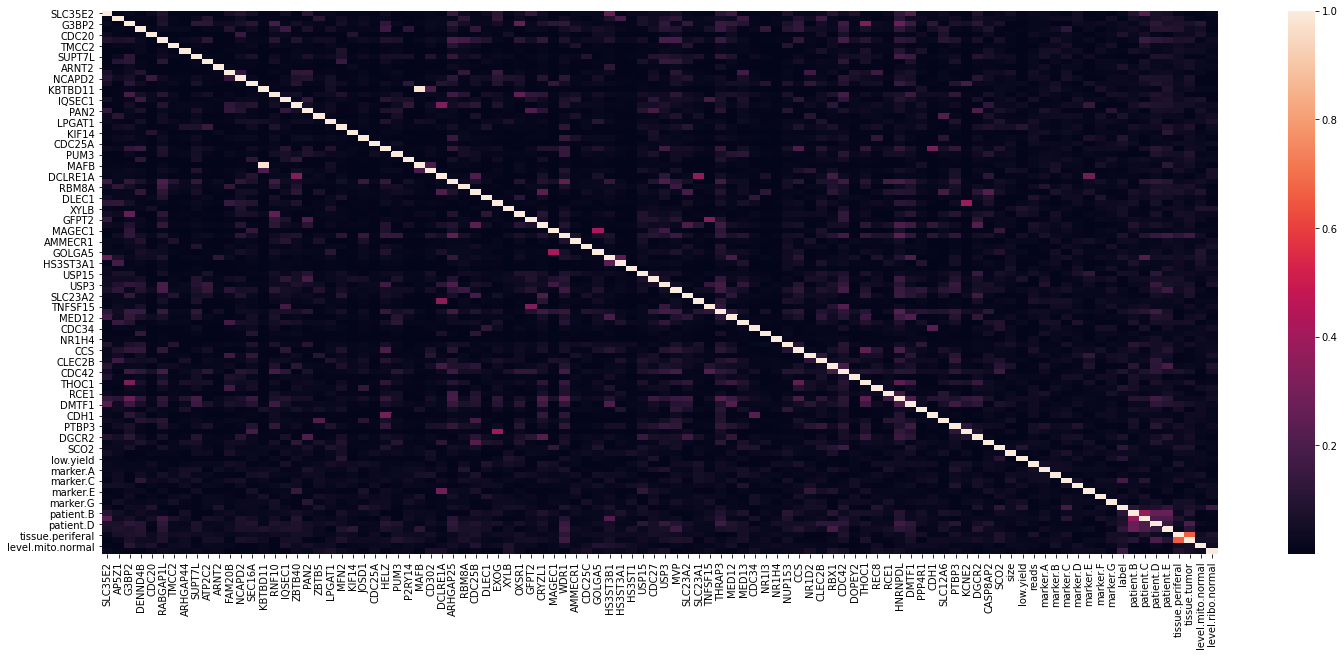

In [25]:
fig=plt.figure(figsize=(25, 10))
sns.heatmap(correlation_matrix.iloc[-100:,-100:])

In [ ]:
%%time

correlated_features = []
for i, col in enumerate(correlation_matrix.columns):
    if col in correlated_features: 
        continue
    for j, row in enumerate(correlation_matrix.columns[i+1:]):
        if correlation_matrix[col][row] >= correlation_threshold:
            if row == target:
                print(f"Target has high correlation with {col}, corr={correlation_matrix[col][row]}")  # in case there might be a decisive feature
            else:
                correlated_features.append(row)

correlated_features = np.unique(correlated_features)

In [ ]:
print(f"REMOVING {correlated_features.size} FEATURES")

In [ ]:
%%time

# Remove corrolated columns
train_df = train_df.drop(columns=correlated_features)
test_df = test_df.drop(columns=correlated_features)

> To go futher : 
* [Feature selection — Correlation and P-value](https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf)
* univariate selection with t-test assessing whether the means of the features are significantly different
* multivariate feature selection are interesting to explore (not the naive approaches which could be O(2^d))

#### Save pre-processed data frame

For later use. Saves time for next time.

In [ ]:
train_df.shape()

In [ ]:
%%time

# Save pre-processed data frame to CSVs
train_df.to_csv(train_fn[:-4] + "-corr_thresh_" + str(correlation_threshold) + ".csv", index=True)
test_df.to_csv(test_fn[:-4] + "-corr_thresh_" + str(correlation_threshold) + ".csv", index=True)

### Parse data frames to sparse arrays

For faster computing with scikit-learn library. From now on we'll be using numpy arrays and no pandas data frames anymore.

In [ ]:
train_df.astype(pd.SparseDtype("float", 0.0)).sparse.density

> When a data frame's sparsity is larger than 0.10 it is interesting to convert to a sparse data type.

In [ ]:
# Separate features and labels
train_features = sparse.csr_matrix(train_df.loc[:, train_df.columns != target], dtype="float64")
train_labels = train_df.loc[:, target].values

test_features = sparse.csr_matrix(test_df.loc[:, test_df.columns != target], dtype="float64")
test_labels = test_labels_df.iloc[:,0].values  # again : these exist only as validation (and are not given initially)

### Removing low-variance features

In [ ]:
variance_filter = VarianceThreshold(threshold=variance_threshold) 
variance_filter.fit(train_features)

In [ ]:
print(f"REMOVING {train_features.shape[1] - np.count_nonzero(variance_filter.get_support())} FEATURES")

In [ ]:
train_features = variance_filter.transform(train_features)
test_features = variance_filter.transform(test_features)

### Scaling features

Some classifiers (ex: MLP and SVC) are sensitive to feature scaling. Skipped for decision trees.

In [ ]:
# scaler = preprocessing.StandardScaler(with_mean=False)  # with_mean=False because of sparse matrix
# scaler.fit(train_features)

In [ ]:
# train_features = scaler.transform(train_features)
# test_features = scaler.transform(test_features)

In [ ]:
train_features.shape

> It is interesting to note the shape of the data set now. A bunch of features have been removed and the data is ready to be used in the trainig of the models.

## Model parametering

In [ ]:
# Creating new Multi-Layer Perceptron classifier
def MLP_classifier(hidden_layer_sizes=(100,), activation="tanh", alpha=0.0001, max_iter=200, mlp_tol=0.0001):
    classifier = MLPClassifier(solver="lbfgs",  # the default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.
                               hidden_layer_sizes=hidden_layer_sizes,  # the ith element represents the number of neurons in the ith hidden layer
                               activation=activation,  # ‘identity’, ‘logistic’, ‘tanh’, ‘relu’
                               alpha=alpha,  # regularization term
                               max_iter=max_iter,       
                               tol=mlp_tol,  # tolerance for the optimization. When the loss or score is not improving by at least tol, convergence is considered to be reached and training stops
                               max_fun=50000,  # maximum number of loss function calls. The solver iterates until convergence (determined by ‘tol’), number of iterations reaches max_iter, or this number of loss function calls
                               warm_start=False,  # reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution
                               verbose=False, 
                               random_state=RANDOM_STATE)
    return classifier

# Creating new Random Forest classifier
def RF_classifier(n_estimators=100, criterion="gini", max_depth=None, ccp_alpha=0.0):
    classifier = RandomForestClassifier(n_estimators=n_estimators,  # number of trees in the forest
                                        criterion=criterion, # "gini" "entropy" - function to measure the quality of a split
                                        max_depth=max_depth,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features="auto",
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.01,
                                        min_impurity_split=None,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=-1,  # number of jobs to run in parallel, -1 means using all processors
                                        random_state=RANDOM_STATE,
                                        verbose=0,
                                        warm_start=False,
                                        class_weight=train_df[target].value_counts().to_dict(),
                                        ccp_alpha=ccp_alpha,  # complexity parameter used for Minimal Cost-Complexity Pruning
                                        max_samples=None)
    return classifier

# Creating new Support Vector classifier
def SVC_classifier(C=1.0, kernel="rbf", degree=3, gamma="scale", coef0=0.0, svc_tol=0.001):
    classifier = SVC(C=C,  # regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive
                     kernel=kernel,  # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
                     degree=degree,  # degree of the polynomial kernel function (‘poly’). Ignored by all other kernels
                     gamma=gamma,  # kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
                     coef0=coef0,  # independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’
                     shrinking=True,  # whether to use the shrinking heuristic
                     tol=svc_tol, 
                     cache_size=16000,  # 16GB, def:200MB
                     class_weight=train_df[target].value_counts().to_dict(),
                     verbose=False, 
                     max_iter=-1, 
                     break_ties=False, 
                     random_state=RANDOM_STATE)
    return classifier

# Creating new AdaBoost classifier
def AdaBoost_classifier(base_estimator=None, ab_n_estimators=50, ab_learning_rate=1.0):
    classifier = AdaBoostClassifier(base_estimator=base_estimator,
                                    n_estimators=ab_n_estimators,
                                    learning_rate=ab_learning_rate,
                                    algorithm='SAMME',  # ‘SAMME’, ‘SAMME.R’. For SAMME.R real boosting algorithm : base_estimator must support calculation of class probabilities.
                                    random_state=RANDOM_STATE)
    return classifier

# Creating new DL8.5 classifier
def DL85_classifier(max_depth, min_sup, time_limit=0):
    classifier = DL85Classifier(max_depth=max_depth,
                                min_sup=min_sup,
                                time_limit=time_limit)  # max_error parameter ?
    return classifier

# Creating new Grid Search CV
def GridSearchCV_searcher(estimator, param_grid, cv):
    searcher = GridSearchCV(estimator, param_grid, 
                            scoring="balanced_accuracy", 
                            n_jobs=-1, 
                            refit=True, 
                            cv=cv, 
                            verbose=0, 
                            pre_dispatch="2*n_jobs", 
                            error_score="raise", 
                            return_train_score=False)
    return searcher

> It is important to note that `class_weight` has to be defined when possible to adress the imbalance problem.

In [ ]:
# Hyper-parameter alternatives
mlp_hp = {"hidden_layer_sizes": [(64,64,32,32,16)],
          "activation": ["tanh"],
          "alpha": [0.0001],
          "max_iter": [2000],
          "tol": [0.00001]
         }

rf_hp = {"n_estimators": [50, 100, 200],
         "criterion": ["gini"],
         "max_depth": [5, 10, 30],
         "ccp_alpha": [0.00001,],
        }

svc_hp = {"C": [4, 5], 
          "kernel": ["sigmoid"],  # "poly", "rbf", "sigmoid"
          "degree": [3],  # , 5, 10, 100
          "gamma": [1/12000.0, 1/13000.0], 
          "coef0": [0.9, 1], 
          "tol": [0.0001]
         }

ab_hp = {"base_estimator": [None],
         "n_estimators": [50], 
         "learning_rate": [1.0]
        }


best_mlp_hp, best_rf_hp, best_svc_hp, best_ab_hp= None, None, None, None

> * A note on chosing between Gini and entropy can be found [here](https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb)
* A comment on model selection : 
 * when #samples << dimensions
   * MLP : often not best approach 
   * linear models : often good
 * to go further : [voting classifier with majority voting](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

## Nested K-Cross Validation loops

Nesting is to avoid optimistic evaluation of hyper-parameters.

In [ ]:
K_ext = 10
validation_size = 0.2
K_int = 5

mlp_accuracies = []
rf_accuracies = []
svc_accuracies = []

In [ ]:
splitter = StratifiedShuffleSplit(n_splits=K_ext, test_size=validation_size, random_state=RANDOM_STATE)  # partition D into T_i sets accounting for test_size, K_ext times
for k, (train_indices, validation_indices) in enumerate(splitter.split(train_features, train_labels)):  # for k in 1:K_ext :
    # S_k = D - T_k
    train_features_cv = train_features[train_indices]
    train_labels_cv = train_labels[train_indices]

    validation_features_cv = train_features[validation_indices]
    validation_labels_cv = train_labels[validation_indices]
        
    print('\033[1m' + f"Iteration {k+1}/{K_ext}" + '\033[0m')  # printing in bold
    
    
    # BEGIN INNER LOOP
    
    if K_int < 2:  # no inner loop (no hyper-param CV)
#         hidden_layer_sizes, activation, alpha, max_iter, mlp_tol = mlp_hp["hidden_layer_sizes"][0], mlp_hp["activation"][0], mlp_hp["alpha"][0], mlp_hp["max_iter"][0], mlp_hp["tol"][0]
        n_estimators, criterion, max_depth, min_samples_leaf, ccp_alpha = rf_hp["n_estimators"][0], rf_hp["criterion"][0], rf_hp["max_depth"][0], rf_hp["min_samples_leaf"][0], rf_hp["ccp_alpha"][0]
        C, kernel, degree, gamma, coef0, svc_tol = svc_hp["C"][0], svc_hp["kernel"][0], svc_hp["degree"][0], svc_hp["gamma"][0], svc_hp["coef0"][0], svc_hp["tol"][0]
        base_estimator, ab_n_estimators, ab_learning_rate = ab_hp["base_estimator"][0], ab_hp["n_estimators"][0], ab_hp["learning_rate"][0]
    else:
        # partition S_k into K_int disjoint sets TT_i
        # for_each hp in HP :
#         mlp_hp_searcher = GridSearchCV_searcher(MLP_classifier(), param_grid=mlp_hp, cv=K_int)
        rf_hp_searcher = GridSearchCV_searcher(RF_classifier(), param_grid=rf_hp, cv=K_int)
        svc_hp_searcher = GridSearchCV_searcher(SVC_classifier(), param_grid=svc_hp, cv=K_int)
        ab_hp_searcher = GridSearchCV_searcher(AdaBoost_classifier(), param_grid=ab_hp, cv=K_int)
        
        print("Finding hyper-params ...")
        # SS_k' = S_k - TT_k'
        # M = MLP(SS_k', hp)
        # for k' in 1:K_int :

#         mlp_hp_searcher.fit(train_features_cv, train_labels_cv)
#         print("   MLP hp found : ", end="")
#         best_mlp_hp = mlp_hp_searcher.best_params_
#         print(best_mlp_hp)

        rf_hp_searcher.fit(train_features_cv, train_labels_cv)
        print("   RF hp found : ", end="")
        best_rf_hp = rf_hp_searcher.best_params_
        print(best_rf_hp)
        
        svc_hp_searcher.fit(train_features_cv, train_labels_cv)
        print("   SVC hp found : ", end="")
        best_svc_hp = svc_hp_searcher.best_params_
        print(best_svc_hp)
        
        ab_hp_searcher.fit(train_features_cv, train_labels_cv)
        print("   Ada hp found : ", end="")
        best_ab_hp = ab_hp_searcher.best_params_
        print(best_ab_hp)
        
        # get optimal hyper-parameters
#         hidden_layer_sizes, activation, alpha, max_iter, mlp_tol = best_mlp_hp["hidden_layer_sizes"], best_mlp_hp["activation"], best_mlp_hp["alpha"], best_mlp_hp["max_iter"], best_mlp_hp["tol"]
        n_estimators, criterion, max_depth, ccp_alpha = best_rf_hp["n_estimators"], best_rf_hp["criterion"], best_rf_hp["max_depth"], best_rf_hp["ccp_alpha"]
        C, kernel, degree, gamma, coef0, svc_tol = best_svc_hp["C"], best_svc_hp["kernel"], best_svc_hp["degree"], best_svc_hp["gamma"], best_svc_hp["coef0"], best_svc_hp["tol"], 
        base_estimator, ab_n_estimators, ab_learning_rate = best_ab_hp["base_estimator"], best_ab_hp["n_estimators"], best_ab_hp["learning_rate"]

    # END INNER LOOP    
    
    
#     mlp_clf = MLP_classifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, alpha=alpha, max_iter=max_iter, mlp_tol=mlp_tol)
    rf_clf = RF_classifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, ccp_alpha=ccp_alpha)
    svc_clf = SVC_classifier(C=C, kernel=kernel, degree=degree, gamma=gamma, coef0=coef0, svc_tol=svc_tol)
    ab_clf = AdaBoost_classifier(base_estimator=base_estimator, ab_n_estimators=ab_n_estimators, ab_learning_rate=1ab_learning_rate)
    
    print("Training ...")
#     mlp_clf.fit(train_features_cv, train_labels_cv)
    rf_clf.fit(train_features_cv, train_labels_cv)
    svc_clf.fit(train_features_cv, train_labels_cv, sample_weight=None)  # TODO sample_weight
    ab_clf.fit(train_features_cv, train_labels_cv)
    
    # Compute error rates of M* on T_k
#     mlp_predictions = mlp_clf.predict(validation_features_cv)
    rf_predictions = rf_clf.predict(validation_features_cv)
    svc_predictions = svc_clf.predict(validation_features_cv)
    ab_predictions = ab_clf.predict(validation_features_cv)
    
    # Compute balanced classification rate
#     mlp_bcr = metrics.balanced_accuracy_score(y_pred=mlp_predictions, y_true=validation_labels_cv)
    rf_bcr = metrics.balanced_accuracy_score(y_pred=rf_predictions, y_true=validation_labels_cv)
    svc_bcr = metrics.balanced_accuracy_score(y_pred=svc_predictions, y_true=validation_labels_cv)
    ab_bcr = metrics.balanced_accuracy_score(y_pred=ab_predictions, y_true=validation_labels_cv)
    
    # Average (over various T_k) error rate of M*
#     mlp_accuracies.append(mlp_bcr)
#     print(f"   MLP : {mlp_bcr}")
    
    rf_accuracies.append(rf_bcr)
    print(f"   RF  : {rf_bcr}")
    
    svc_accuracies.append(svc_bcr)
    print(f"   SVC : {svc_bcr}")
     
    ab_accuracies.append(av_bcr)
    print(f"   Ada : {av_bcr}")

In [ ]:
# mlp_mean = np.mean(mlp_accuracies)
# mlp_std = np.std(mlp_accuracies)
rf_mean = np.mean(rf_accuracies)
rf_std = np.std(rf_accuracies)
svc_mean = np.mean(svc_accuracies)
svc_std = np.std(svc_accuracies)
ab_mean = np.mean(ab_accuracies)
ab_std = np.std(ab_accuracies)

# print(f"MLP accuracy  : {np.round(mlp_mean,4)}\t std={np.round(mlp_std, 4)}")
print(f"RF accuracy   : {np.round(rf_mean,4)}\t std={np.round(rf_std, 4)}")
print(f"SVC accuracy  : {np.round(svc_mean,4)}\t std={np.round(svc_std, 4)}")
print(f"Ada accuracy  : {np.round(ab_mean,4)}\t std={np.round(ab_std, 4)}")

## Final prediction

Select by hand a classifier to train based on results just above.

Train on all training set in order to have the best performing classifier possible.

In [ ]:
final_clf = RF_classifier(ccp_alpha=1e-05, criterion='gini', max_depth=5, n_estimators=50)

final_clf.fit(train_features, train_labels)

In [ ]:
pred_acc = rf_mean
pred_std = rf_std

In [ ]:
# Predict labels of testing data
predictions = final_clf.predict(test_features).astype(int)

In [ ]:
test_labels_prediction_df = pd.DataFrame({"Prediction": predictions}, index = test_df.index)
test_labels_prediction_df.Prediction.value_counts()

In [ ]:
test_labels_prediction_df.iloc[i, :]

In [ ]:
actual_acc = metrics.balanced_accuracy_score(y_pred=test_labels_prediction_df, y_true=test_labels_df)

print(f"Performance prediction    : {pred_acc}")
print(f"Actual performance        : {actual_acc}")
print(f"                    delta : {abs(pred_acc - actual_acc)}")

# Output CSV

In [ ]:
output_fn = "Test_labels_prediction_" + str(final_clf.__class__.__name__) + "_" + str(np.round(pred_acc, 4)) + "_" + str(np.round(pred_std, 4)) + ".csv"

test_labels_prediction_df.to_csv(output_fn, index=True)

# For later (or not)

In [ ]:
"""
# Training model
classifier.fit(train_features, train_labels)
"""

"""
# Predict labels of testing data
predicted_labels = classifier.predict(test_features)

accuracy = metrics.accuracy_score(test_labels, predicted)  # computing accuracy:

# Compute the mean accuracy on the test data and labels
accuracy = classifier.score(test_features, predicted_labels)
"""


"""
Nested K-Cross Validation loops
to avoid optimistic evaluation of hyper-parameters

input : D dataset
input : K_ext
input : K_int
input : HP hyper-parameters
input = MLP multi-layer perceptron algorythm that trains using backpropagation

partition D into K_ext disjoint sets T_i
for k in 1:K_ext :
    S_k = D - T_k
    partition S_k into K_int disjoint sets TT_i
    for_each hp in HP :
        for k' in 1:K_int :
            SS_k' = S_k - TT_k'
            M = MLP(SS_k', hp)
            compute error rates of M on TT_k'
        store average (over various TT_k') error rates of MLP with hp
    M* = MLP(S_k, hp*)
    compute error rates of M* on T_k
return average (over various T_k) error rate of M*
"""

In [ ]:
"""
Determint data size importance : 

>>> from sklearn.model_selection import learning_curve
>>> from sklearn.svm import SVC

>>> train_sizes, train_scores, valid_scores = learning_curve(
...     SVC(kernel='linear'), X, y, train_sizes=[50, 80, 110], cv=5)
>>> train_sizes
array([ 50, 80, 110])
>>> train_scores
array([[0.98..., 0.98 , 0.98..., 0.98..., 0.98...],
       [0.98..., 1.   , 0.98..., 0.98..., 0.98...],
       [0.98..., 1.   , 0.98..., 0.98..., 0.99...]])
>>> valid_scores
array([[1. ,  0.93...,  1. ,  1. ,  0.96...],
       [1. ,  0.96...,  1. ,  1. ,  0.96...],
       [1. ,  0.96...,  1. ,  1. ,  0.96...]])
       
"""

In [ ]:
"""
# Save correlation matrix
with open("intermediaries/" + correlation_matrix_file + ".pkl", "wb") as outfile:
    pickle.dump(correlation_matrix, outfile, pickle.HIGHEST_PROTOCOL)
    

%%time

# Load correlation matrix
with open("intermediaries/" + correlation_matrix_file + ".pkl", 'rb') as infile:
    correlation_matrix = pickle.load(infile)



# Save most correlated features
with open("intermediaries/" + corr_cols_argmax_file + ".pkl", "wb") as outfile:
    pickle.dump(corr_cols_argmax, outfile, pickle.HIGHEST_PROTOCOL)
    


%%time

# Load most correlated features
with open("intermediaries/" + corr_cols_argmax_file + ".pkl", 'rb') as infile:
    corr_cols_argmax = pickle.load(infile)
    
"""

In [ ]:
"""
conf_m = metrics.confusion_matrix(y_pred=[1,0,0,1], y_true=[1,1,1,0])
conf_m
tn, fp, fn, tp = conf_m.ravel()
# tn, fp, fn, tp = 90,10,10,90
cm = np.array([[tn,fp],[fn,tp]])
bcr = (tp/(tp+fn) + tn/(fp+tn)) * 0.5
print(cm, bcr)
"""

### Resampling

In [ ]:
def resample(X, y, method="down", rate=1):
    """
    Up- or down-samples minority- or majority class
    @argument rate is the rate at which the majority class should be represented after resampling
    
    TODO is still *very* inefficient ...
    """

    if method == "down": # DOWNSAMPLING MAJORITY CLASS
        priors = pd.Series(y).value_counts().to_dict()

        maj_class = list(priors.keys())[np.argmax(list(priors.values()))]
        min_class = list(priors.keys())[np.argmin(list(priors.values()))]

        new_maj_prior = np.ceil(priors[min_class] * rate).astype(int)
        if new_maj_prior > priors[maj_class]:
            raise ValueError("rate is too high")
        drop_maj_prior = priors[maj_class] - new_maj_prior

        
        X_maj = X[np.where(y == maj_class)]
        X_min = X[np.where(y == min_class)]
        
        X_down = np.append(X_maj, X_min, axis=0)
        X_down = np.reshape(X_down, X.shape)[drop_maj_prior:]
        
        y_down = np.append(y[np.where(y == maj_class)], y[np.where(y == min_class)])
        y_down = np.reshape(y_down, y.shape)[drop_maj_prior:]
        
        
        idx = np.arange(y_down.shape[0])
        np.random.shuffle(idx)
        
        return X_down[idx], y_down[idx]
    
    elif method =="up": # UPSAMPLING MINORITY CLASS
        # TODO
        return X, y
    
    else:
        raise ValueError("method argument should either be 'up' or 'down'")